# Modelling

### Questions Considered Before Modeling

As modeling begins, it would generally be helpful to have clarity on the following points, as they could influence key decisions in a real-world setting:

1. How will predictions be used? Understanding whether predictions support human review or trigger automated actions would affect how cautious the model should be.
2. What is more costly: false positives or false negatives?  
This would help determine how conservative the model should be, especially when selecting thresholds or optimizing for specific types of errors.
3. Will the model be used in real-time or batch processing?  
Clarifying this helps assess whether model performance (e.g., speed, memory footprint) needs to be a priority.

###  General approach

Given the limited context - aside from the note that this dataset is based on a real bot incident and contains at least one bot (≥1% of requests) - modeling will begin with the **Isolation Forest** algorithm, a commonly used approach for unsupervised anomaly detection.

The model will be saved as part of a complete end-to-end pipeline, as reqested in the assignment requirements.

After training, the results will be reviewed to understand what types of requests the algorithm is flagging, the potential reasoning behind those anomalies, and which features appear to contribute most to the outlier scores.

Since the input dataset was originally split into three parts _(note: during feature engineering, the first two datasets were consolidated as fine-tuning won't be performed)_, the trained model will be evaluated on the holdout set. This will help assess the model’s stability and generalization to unseen data.


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import pickle

# modelling
from sklearn.ensemble import IsolationForest

# cleaning
from urllib.parse import unquote

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import umap

# evaluation
from kneed import KneeLocator
import shap

# add parent directory to path for absolute imports
sys.path.append(os.path.abspath('..'))
from transform import FeatureTransformation

In [30]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Read and transform raw data

In [52]:
# load data
df_train_raw = pd.read_csv("../data/train.csv", sep="\t")
df_test_raw = pd.read_csv("../data/test.csv", sep="\t")

# combining after all as there won't be any fine tuning on the test set
df_all_raw = pd.concat([df_train_raw, df_test_raw], axis=0, ignore_index=True)

# transform data
feature_transformation = FeatureTransformation(
    fasttext_model_path="../models/cc.en.300.bin",
    svd_model_path="../models/svd_model.pkl",
)
df_train = feature_transformation.transform(df_all_raw)

2025-07-14 22:46:21,452 - transform - INFO - FeatureTransformation initialized
2025-07-14 22:46:22,611 - transform - INFO - Starting transformation pipeline with 14064 rows and 5 columns
2025-07-14 22:46:28,169 - transform - INFO - After cleaning: 14064 rows and 25 columns
2025-07-14 22:46:28,230 - transform - INFO - After categorical encoding: 14064 rows and 32 columns
2025-07-14 22:46:28,243 - transform - INFO - After dropping constant columns: 14064 rows and 25 columns
2025-07-14 22:46:28,308 - transform - INFO - After sparse encoding: 14064 rows and 33 columns
2025-07-14 22:46:28,797 - transform - INFO - SVD explained variance: 0.610
2025-07-14 22:46:28,820 - transform - INFO - After SVD sparse combination: 14064 rows and 32 columns
2025-07-14 22:46:28,894 - transform - WARNING - Found 3 invalid country codes, replacing with 'unknown'
2025-07-14 22:46:47,401 - transform - INFO - After domain feature extraction: 14064 rows and 340 columns
2025-07-14 22:46:54,386 - transform - INFO -

In [53]:
param_df = df_all_raw['params_dict'].apply(pd.Series)
df_manual = pd.concat([
    df_all_raw.drop(columns=['url_params','params_dict']),
    param_df],
    axis=1
)
df_manual['q'] = df_manual['q'].apply(unquote)

In [54]:
# Check data types
print("Data types:")
print(df_train.dtypes.value_counts())

# Check for any non-numeric data
non_numeric = df_train.select_dtypes(exclude=['number'])
print(f"\nNon-numeric columns: {list(non_numeric.columns)}")

Data types:
float32    600
int64       29
float64     13
int32        1
Name: count, dtype: int64

Non-numeric columns: []


### Train Isolation Forest Model

The Isolation Forest algorithm requires a `contamination` parameter to define the expected proportion of outliers. While setting it to `0.01` would align with the hint that at least 1% of traffic is bot-related, this would force the model to flag exactly 1% of data as anomalies - based purely on the lowest anomaly scores.

Instead, `contamination='auto'` is used to let the model infer the threshold from the data itself, allowing for a more natural separation if one exists.

In [55]:
iso_forest = IsolationForest(
    contamination='auto',  # Expected proportion of anomalies
    random_state=42,
    n_estimators=100,
    max_samples='auto'
)

# Fit and predict
anomaly_scores_train = iso_forest.fit_predict(df_train) # predicts -1 for anomalies
anomaly_scores_decision_train = iso_forest.decision_function(df_train)

#### Analyze results

In [56]:
# Create results DataFrame
res_df_train = df_train.copy()
res_df_train = res_df_train.join(df_train_raw[['datetime']]) # add back original timestamp

res_df_train['anomaly_score'] = anomaly_scores_decision_train
res_df_train['is_anomaly'] = (anomaly_scores_train == -1)

In [57]:
# Score distribution
print("\nAnomaly score statistics:")
print(f"Mean: {res_df_train['anomaly_score'].mean():.4f}")
print(f"Std: {res_df_train['anomaly_score'].std():.4f}")
print(f"Min: {res_df_train['anomaly_score'].min():.4f}")
print(f"Max: {res_df_train['anomaly_score'].max():.4f}")

n_total_train = len(res_df_train)
n_anom = res_df_train["is_anomaly"].sum()
anomaly_percentage = (n_anom / n_total_train) * 100
print(f"\nAnomalies:")
print(f"Total samples: {n_total_train}")
print(f"Anomalies detected: {n_anom}")
print(f"Anomaly percentage: {anomaly_percentage:.2f}%")


Anomaly score statistics:
Mean: 0.1192
Std: 0.0450
Min: -0.2083
Max: 0.1670

Anomalies:
Total samples: 14064
Anomalies detected: 466
Anomaly percentage: 3.31%


_Note_:  The detected anomaly rate is 3.31%, which is notably higher than the hinted minimum of 1%. However, without access to ground-truth labels, it's difficult to determine whether this rate is appropriate or meaningful.

##### Elbow method on splitting the data

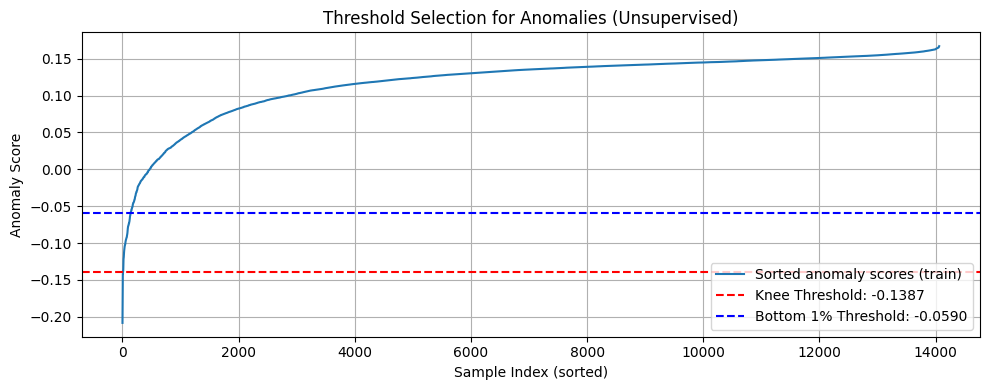

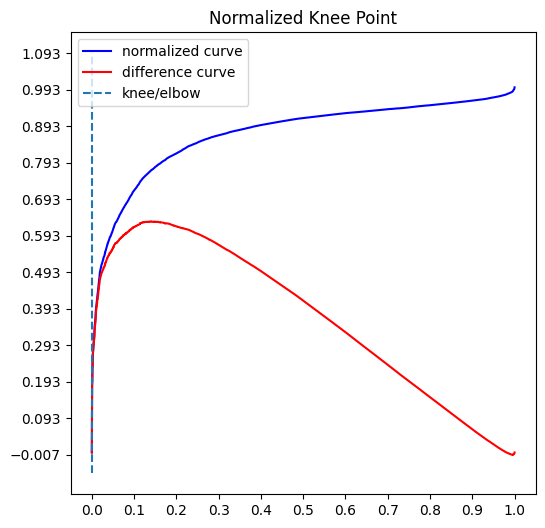

In [58]:
# Sort scores (lower = more anomalous)
sorted_scores = np.sort(anomaly_scores_decision_train)

# Find knee point (where curvature changes most)
knee = KneeLocator(
    x=range(len(sorted_scores)),
    y=sorted_scores,
    curve='concave',
    direction='increasing',
    online=False
)
knee_threshold = sorted_scores[knee.knee]
# calculating also bottom 1% threshold
bottom_threshold = np.percentile(anomaly_scores_decision_train, 1)

plt.figure(figsize=(10, 4))
plt.plot(sorted_scores, label='Sorted anomaly scores (train)')
plt.axhline(
    knee_threshold,
    color='red',
    linestyle='--',
    label=f'Knee Threshold: {knee_threshold:.4f}'
)
plt.axhline(
    bottom_threshold,
    color='blue',
    linestyle='--',
    label=f'Bottom 1% Threshold: {bottom_threshold:.4f}'
)

plt.title('Threshold Selection for Anomalies (Unsupervised)')
plt.xlabel('Sample Index (sorted)')
plt.ylabel('Anomaly Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

knee.plot_knee_normalized()

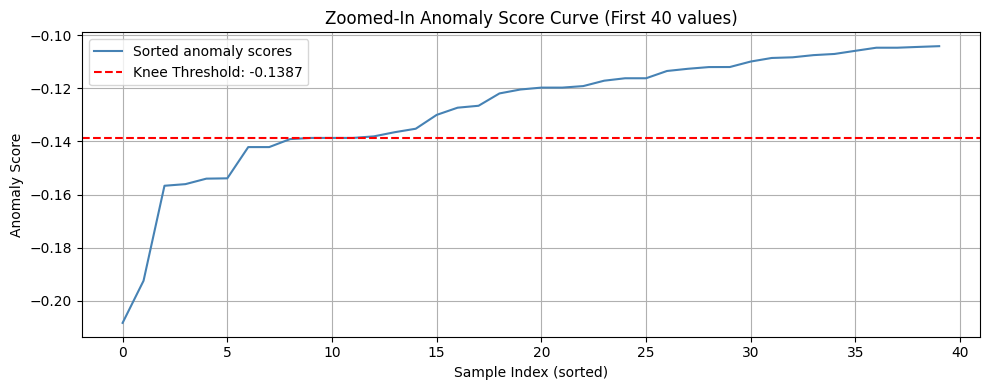

In [59]:
# Zoom in on first N samples to understand better that curve
zoom_limit = 40

# Plot
plt.figure(figsize=(10, 4))
plt.plot(
    range(len(sorted_scores))[:zoom_limit],
    sorted_scores[:zoom_limit], 
    label=f'Sorted anomaly scores',
    color='steelblue'
)

plt.axhline(
    knee_threshold,
    color='red',
    linestyle='--',
    label=f'Knee Threshold: {knee_threshold:.4f}'
)

plt.xlabel("Sample Index (sorted)")
plt.ylabel("Anomaly Score")
plt.title(f"Zoomed-In Anomaly Score Curve (First {zoom_limit} values)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
knee_anomalies_count = sum(anomaly_scores_decision_train < knee_threshold)
print(
    "Using knee threshold as the cutoff value for anomalies, "
    f"{knee_anomalies_count} anomalies were identified, which represents "
    f"{knee_anomalies_count / len(anomaly_scores_decision_train) * 100:.2f}% "
    "of the training data."
)

Using knee threshold as the cutoff value for anomalies, 9 anomalies were identified, which represents 0.06% of the training data.


While 0.06% would be a very conservative threshold, this needs to be checked manually. The assumption is that there are strong signals these are real anomalies.

In [ ]:
manually_check = res_df_train[res_df_train['anomaly_score'] < knee_threshold].index

df_manual.loc[manually_check]

,datetime,region,browser,device,hour,n,f,d,sld,st,nt,r,adx,adx_name,ttc,q,ct,kl,kp,bkl,lsexp1,om,atb,atbva,va,atbexp
2073,2019-12-02 03:55:46,Mars,Edge,Android,3,1,1,www.o2.co.uk,1,mobile_search_intl,0,0,none,none,2383,no,GB,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3585,2019-12-02 06:17:28,Saturn,Edge,Android,6,1,1,englishlive.ef.com,1,mobile_search_intl,0,0,none,none,59514,di,IN,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4139,2019-12-02 07:03:28,Saturn,Chrome,Android,7,1,1,shop.wwe.com,1,mobile_search_intl,0,0,none,none,8378,txt,IN,wt-wt,-1,NaN,NaN,news:i:1,NaN,NaN,NaN,NaN
9096,2019-12-02 13:16:03,Mars,Chrome,Android,13,1,1,www.ah.nl,1,mobile_search_intl,0,0,none,none,1960,vp,NL,nl-nl,-1,NaN,NaN,news:i:1,NaN,NaN,NaN,NaN
10054,2019-12-02 14:16:33,Mars,Chrome,Android,14,1,1,www.klm.com,1,mobile_search_intl,0,null,none,none,8625,oak,NL,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11582,2019-12-02 15:45:56,Mars,Edge,Android,15,1,1,o2.co.uk,1,mobile_search_intl,0,0,oag,none,2512,no,GB,uk-en,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12227,2019-12-02 16:28:26,Mars,Edge,Android,16,1,1,www.apc.fr,1,mobile_search_intl,0,0,none,none,1177,nou,GB,wt-wt,-1,NaN,b,NaN,NaN,NaN,NaN,NaN
12453,2019-12-02 16:44:54,Mars,Safari,Android,16,1,1,www.klm.com,1,mobile_search_intl,0,0,oag,none,2797,oak,GB,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12577,2019-12-02 16:53:20,Mars,Safari,Android,16,1,1,www.klm.com,1,mobile_search_intl,0,0,oag,none,1939,oak,GB,wt-wt,-1,NaN,a,NaN,NaN,NaN,NaN,NaN


Looking at the anomalous observations, several patterns emerge related to query length, query content, domain length, and time-to-click.

Exception: there exsist two observations that have even shorter queries - only a single character. However these one-character queries fall into the `normal_fast` time-to-click bin and have longer (character-wise) ad domains.

##### Anomaly explanation: LIME

The LIME method is used to explain why certain cases are seen as anomalous by building a simple local model around the anomaly score and showing which features mattered most.

In [81]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(
    training_data=df_train.values,
    feature_names=df_train.columns.tolist(),
    mode='regression',
    verbose=True
)

In [85]:
manually_check

Index([2073, 3585, 4139, 9096, 10054, 11582, 12227, 12453, 12577], dtype='int64')

In [ ]:
# let's look at most anomalous case
idx = res_df_train\
    .loc[res_df_train['anomaly_score'] < knee_threshold, 'anomaly_score']\
    .idxmin()
instance = df_train.iloc[idx].values.reshape(1, -1)
explanation = explainer.explain_instance(
    instance.flatten(),
    # preserve column names
    # also (-) to flip score; higher = more anomalous
    predict_fn=lambda x: -iso_forest.decision_function(pd.DataFrame(x, columns=df_train.columns)).reshape(-1, 1),
    num_features=50
)


Intercept 0.062437833586464084
Prediction_local [0.02846611]
Right: -0.20834824973823074


In [95]:
print(f"Explained variance by the model: {explanation.score:.4f}")

Explained variance by the model: 0.1698


The local surrogate model predicted an anomaly score of 0.028 (with an intercept of 0.062), while the actual model output was -0.208. Moreover, the explained variance is only 17%, indicating that LIME provides a poor local approximation in this case.

However, the feature rules generated by the LIME model can still offer insights into what contributes to normal or anomalous observations.

In [101]:
# Get explanation as list of (feature_rule, weight) tuples
exp_list = explanation.as_list()
# Sort by weight
sorted_exp = sorted(exp_list, key=lambda x: x[1])

most_anomalous = sorted_exp[:10]
most_normal = sorted_exp[-3:]

# Print results
print("🔺 Most Anomalous Features:")
for rule, weight in most_anomalous:
    print(f"{rule}: {weight:.4f}")

print("\n🔹 Most Normal Features:")
for rule, weight in reversed(most_normal):  # descending
    print(f"{rule}: {weight:.4f}")


🔺 Most Anomalous Features:
domain_ft_dim_178 > 0.02: -0.0033
q_ft_dim_32 > 0.01: -0.0030
domain_ft_dim_170 <= -0.04: -0.0027
q_ft_dim_252 > 0.01: -0.0024
domain_ft_dim_89 <= -0.03: -0.0024
domain_ft_dim_128 <= -0.07: -0.0023
domain_ft_dim_289 > 0.02: -0.0023
domain_ft_dim_148 > 0.05: -0.0023
domain_ft_dim_183 > 0.00: -0.0022
domain_ft_dim_80 > 0.01: -0.0022

🔹 Most Normal Features:
r_2 <= 0.00: 0.0072
domain_digit_ratio <= 0.00: 0.0047
region_Venus <= 0.00: 0.0046


As suspected, the most anomalous features are primarily related to domain and query embeddings. Since these are dense vector dimensions, their specific meanings are unclear - but these features clearly influence the anomaly score.

On the other hand, features associated with more "normal" behavior include:
- The variable r (though undocumented) not being equal to 2 appears to correlate with typical behavior.
- Domains without digits tend to be considered more normal.
- Being in the Venus region also contributes to normality.

In [ ]:
#with open("03-1_lime_explanation.html", "w") as f:
#    f.write(explanation.as_html())

##### Feature importance: SHAP

Although SHAP is not ideally suited for unsupervised models like `IsolationForest`, it is used here to approximate feature importance. `IsolationForest` does not natively provide feature importances, making SHAP a practical - albeit imperfect - workaround. SHAP values do not directly reflect the tree-based isolation mechanism used by the model, however can give some insight, similar to above approach.


In [107]:
explainer = shap.Explainer(iso_forest, df_train)
shap_values = explainer(df_train)

100%|===================| 14031/14064 [02:35<00:00]        

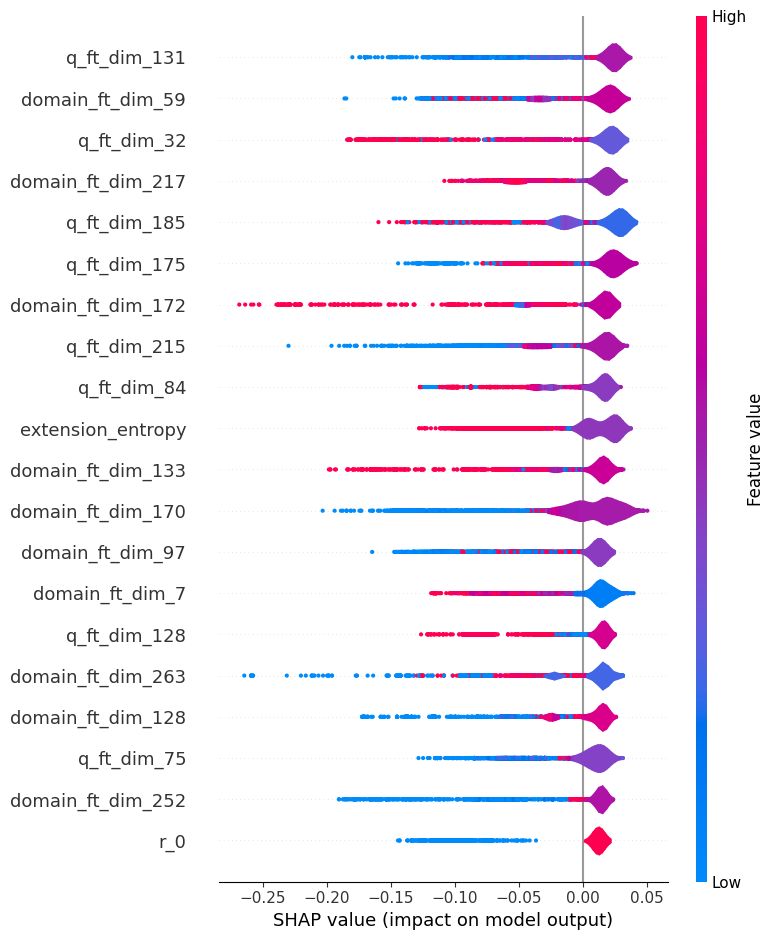

In [108]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_all_idx = np.argsort(mean_abs_shap)
top_n_idx = 20

top_features = df_train.columns[top_all_idx[-top_n_idx:]]

# Subset shap_values for top features only
shap.summary_plot(
    shap_values[:, top_all_idx[-top_n_idx:]],
    df_train.iloc[:, top_all_idx[-top_n_idx:]],
    plot_type='violin'
)


SHAP again highlights query and domain embeddings (`q_ft_dim_*`, `domain_ft_dim_*`) as strong contributors to anomaly scores, despite their abstract nature.

The feature `r` appears more anomalous when it's not `0`, though interestingly, most anomalies identified by the Isolation Forest still have `r = 0`. Understanding what this feature represents is important; if `r` is just noise or lacks meaningful signal, it could be degradading model's performance.

Notably, SHAP shows that low extension_entropy signals anomalous behavior - which sounds reasonable. An entropy of 0 corresponds to short or repetitive domain extensions, such as `.aa`.

##### UMAP
UMAP is a great dimensionality reduction technique used to project high-dimensional data into two dimensions for visualization. It processes the entire feature vector of each observation and maps it into a 2D space, preserving the structure and relationships from the original data as much as possible.

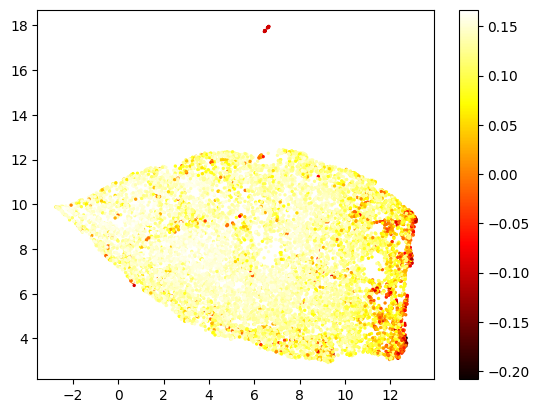

In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding = reducer.fit_transform(df_train)

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=res_df_train['anomaly_score'],
    cmap='hot',
    s=2
)
plt.colorbar()
plt.show()

The UMAP visualization shows that most click traffic forms a dense, central cluster, representing normal behavior. Outliers appear along the edges and in a distinct, isolated region at the top — these represent anomalous behavior based on their separation from the main distribution and low anomaly scores.

Next, out of curiosity, let's visualize only the query, domain, variable `r`, and time-to-click features.

In [128]:
check_cols = [
    x for x in df_train.columns
    if (
        x.startswith('q_')
        or x.startswith('domain_')
        or x.startswith('r')
        or x.startswith('extension_')
        or x == 'ttc_log'
    )
]


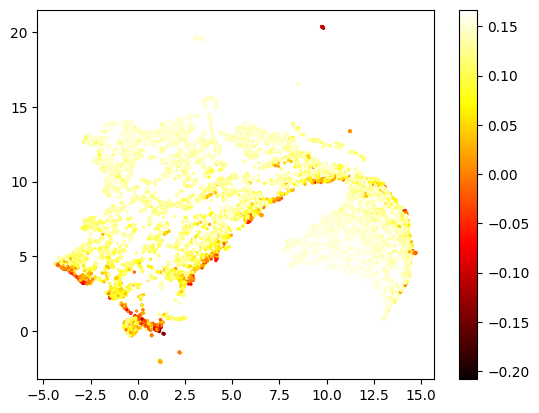

In [130]:
reducer_test = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
embedding_test = reducer_test.fit_transform(df_train[check_cols])

plt.scatter(
    embedding_test[:, 0],
    embedding_test[:, 1],
    c=res_df_train['anomaly_score'],
    cmap='hot',
    s=2
)
plt.colorbar()
plt.show()

The UMAP projection forms a wave-like structure, with anomalies (darker points) concentrated along the outer edges and in a few isolated spots.

##### Plot anomaly score distributions


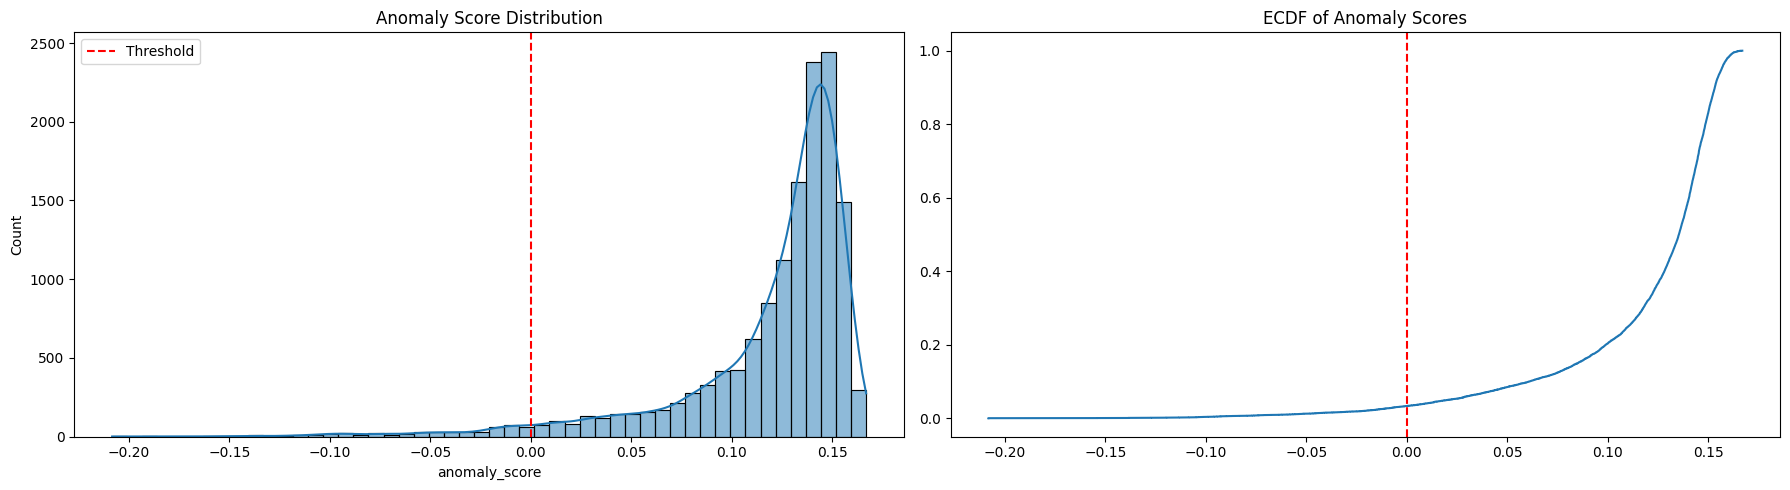

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

def plot_score_distribution(df, threshold):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))

    # Histogram
    sns.histplot(df['anomaly_score'], bins=50, kde=True, ax=axes[0])
    axes[0].axvline(threshold, color='red', linestyle='--', label='Threshold')
    axes[0].set_title("Anomaly Score Distribution")
    axes[0].legend()

    # ECDF
    ecdf = ECDF(df['anomaly_score'])
    axes[1].step(ecdf.x, ecdf.y)
    axes[1].axvline(threshold, color='red', linestyle='--')
    axes[1].set_title("ECDF of Anomaly Scores")

    plt.tight_layout()
    plt.show()

plot_score_distribution(res_df_train, 0)

#### Temporal Behavior of Anomalies

In [163]:
res_df_train['datetime'].describe()

count                            14064
mean     2019-12-02 10:23:54.187499776
min                2019-12-02 00:00:01
25%         2019-12-02 06:10:39.500000
50%         2019-12-02 10:55:35.500000
75%         2019-12-02 14:43:35.500000
max                2019-12-02 19:19:35
Name: datetime, dtype: object

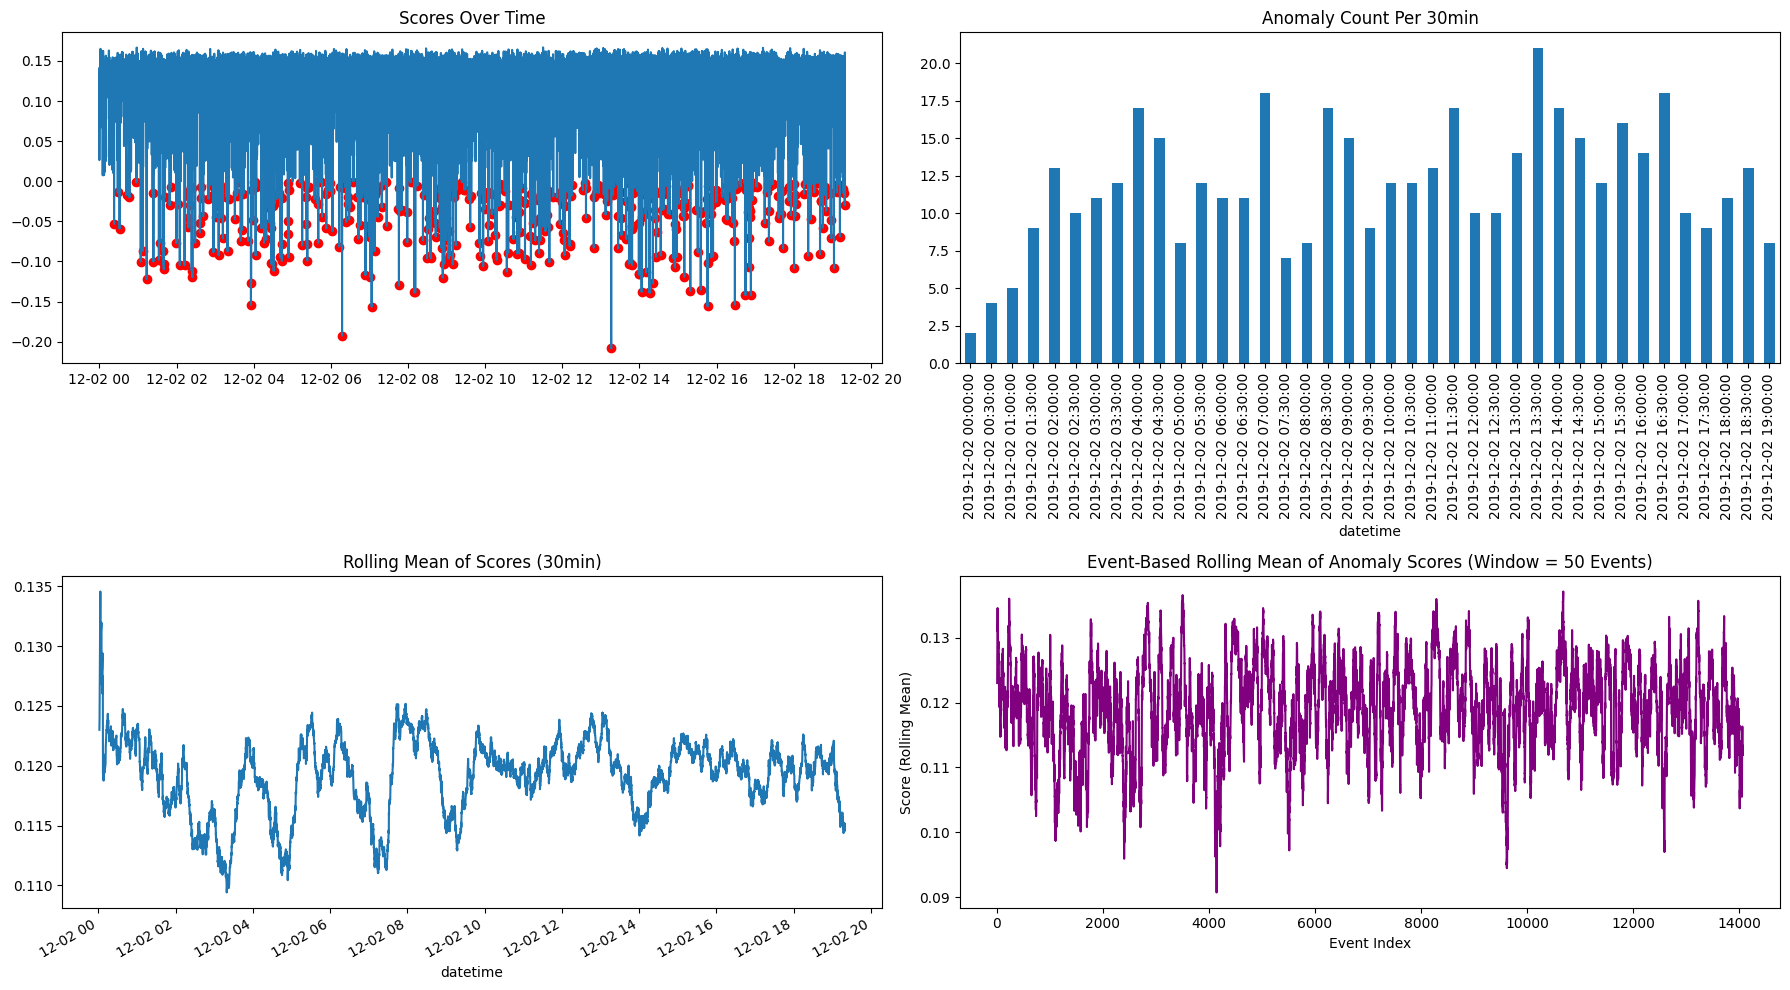

In [166]:
def plot_temporal_patterns(df):
    # Ensure datetime is properly formatted
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['datetime'], format='%H:%M:%S')
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Anomaly scores over time
    axes[0,0].plot(df['datetime'], df['anomaly_score'])
    axes[0,0].scatter(df[df['is_anomaly']]['datetime'], df[df['is_anomaly']]['anomaly_score'], color='red')
    axes[0,0].set_title("Scores Over Time")

    # Anomaly count per 30min
    anomaly_bins = df.set_index('datetime').resample('30min')['is_anomaly'].sum()
    anomaly_bins.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title("Anomaly Count Per 30min")

    # Rolling mean (time-based)
    df_roll = df.set_index('datetime').sort_index()
    roll_mean = df_roll['anomaly_score'].rolling('30min', min_periods=10).mean()
    roll_mean.plot(ax=axes[1, 0])
    axes[1,0].set_title("Rolling Mean of Scores (30min)")

    # Rolling mean (event-based)
    df_sorted = df.sort_values('datetime').reset_index(drop=True)
    df_sorted['rolling_score_event_based'] = df_sorted['anomaly_score']\
        .rolling(window=50, min_periods=10).mean()
    axes[1, 1].plot(df_sorted.index, df_sorted['rolling_score_event_based'], color='purple')
    axes[1, 1].set_title("Event-Based Rolling Mean of Anomaly Scores (Window = 50 Events)")
    axes[1, 1].set_xlabel("Event Index")
    axes[1, 1].set_ylabel("Score (Rolling Mean)")

    plt.tight_layout()
    plt.show()

plot_temporal_patterns(res_df_train)

## Evaluate model's stability on holdout set